This is a complete but still being tested workflow for generating irrigated cropping extents

Go to the user inputs section and input the required info, then run the rest of the cells.
Results will be in your results folder

### Libraries

In [13]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
import dask
import datacube 
from matplotlib import pyplot as plt
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry

import fiona
import rasterio.features
from osgeo import gdal, ogr
import os
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats

#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from load_data import load_data
from transform_tuple import transform_tuple
from imageSeg import imageSeg
from query_from_shp import query_from_shp

## User Inputs

In [15]:
# where is your data and results folder?
data = 'data/'
results = 'results/'

#do I need to load in new data from the datacube
#or have you already saved it previously?
load_fresh_data = True

sensors = ['ls5']

#are we using a polygon to mask the AOI?
polygon_mask = False
shp_fpath = 'data/spatial/murrumbidgee_catchment.shp'

#If not using a polygon then enter your AOI coords
#below:
lat, lon = -30.168, 147.344
latLon_adjust = 0.05

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'percentiles_murrum_test'
year = 'Summer2013-14'

time_period = ('1995-03-06', '1995-03-15')

#What thresholds should I use?
threshold = 0.8
wofs_theshold = 0.15
#-----------------------------------------

In [5]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"

## load data

In [19]:
import datacube
dc = datacube.Datacube(app='load-data-example')

query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
                 'lat': (lat - latLon_adjust, lat + latLon_adjust),
                 'time': time_period}
data = dc.load(product='ls5_nbar_albers', **query)


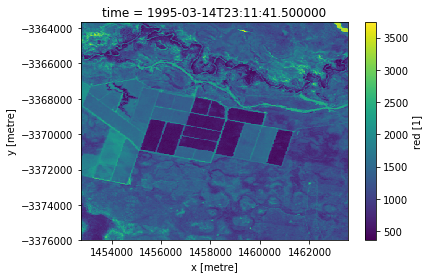

In [21]:
data.red.plot()

In [16]:
#load landsat data    
if load_fresh_data == True:
    if polygon_mask == True:
        #set up query
        query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 0)
        #landsat
        landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors,
                  export_name = data + AOI + "_" + year + '.nc', query=query)
        
        #wofs
        dc = datacube.Datacube(app='wofs')
        del query['time'] 
        wofs_alltime = dc.load(product = 'wofs_summary', **query)
        
        #masking the returned array to the polygon area
        with fiona.open(shp_fpath) as shapes:
                crs = geometry.CRS(shapes.crs_wkt)
                first_geometry = next(iter(shapes))['geometry']
                geom = geometry.Geometry(first_geometry, crs=crs)

        mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                                   out_shape=landsat.geobox.shape,
                                                   transform=landsat.geobox.affine,
                                                   all_touched=False,
                                                   invert=True)
        # Mask the xarrays
        landsat = landsat.where(mask)
        #wofs_alltime = wofs_alltime.where(mask)
        #datacube.storage.storage.write_dataset_to_netcdf(landsat, results + AOI + "_" + year + '.nc')
    else:
        # Set up query
        query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
                 'lat': (lat - latLon_adjust, lat + latLon_adjust),
                 'time': time_period}
        #query['dask_chunks']= {'x': 500, 'y': 500}

        #landsat
#         landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors,
#                   export_name = data + AOI + "_" + year + '.nc', query=query)
        landsat = DEADataHandling.load_clearlandsat(dc=dc, query=query,sensors=['ls5'], 
                bands_of_interest=['red', 'green', 'blue'], satellite_metadata=True,
                masked_prop=0.05, mask_pixel_quality=True)

        
        #wofs
        dc = datacube.Datacube(app='wofs')
        del query['time'] 
        wofs_alltime = dc.load(product = 'wofs_summary', **query)
        
else:
    #load in data from saved netcdf file
    landsat = xr.open_dataset("data/wagga_Summer2017-18.nc")
    
    #landsat = xr.open_dataset('data/' + AOI +  "_" + year + '.nc')
    #load wofs for masking
    query_wofs = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
                 'lat': (lat - latLon_adjust, lat + latLon_adjust)} 
    dc = datacube.Datacube(app='wofs')
    wofs_alltime = dc.load(product = 'wofs_summary', **query_wofs)

Loading ls5 pixel quality
    Loading 1 filtered ls5 timesteps
Combining and sorting ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [17]:
landsat

<xarray.Dataset>
Dimensions:    (time: 1, x: 433, y: 492)
Coordinates:
  * y          (y) float64 -3.364e+06 -3.364e+06 ... -3.376e+06 -3.376e+06
  * x          (x) float64 1.453e+06 1.453e+06 1.453e+06 ... 1.464e+06 1.464e+06
  * time       (time) datetime64[ns] 1995-03-14T23:11:41.500000
Data variables:
    red        (time, y, x) float64 2.043e+03 2.07e+03 2.269e+03 ... 909.0 960.0
    green      (time, y, x) float64 1.467e+03 1.602e+03 ... 929.0 940.0
    blue       (time, y, x) float64 984.0 1.116e+03 1.3e+03 ... 504.0 535.0
    data_perc  (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    satellite  (time) <U3 'ls5'
Attributes:
    crs:      EPSG:3577

## Band Indices and Stats

In [ ]:
#band indices calculation
def ndvi_func(nir, red):
    return ((nir - red)/(nir + red))

def ndvi_ufunc(ds):
    return xr.apply_ufunc(
        ndvi_func, ds.nir, ds.red,
        dask='parallelized',
        output_dtypes=[float])

NDVI_landsat = ndvi_ufunc(landsat).compute()
# NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir').compute()

# x = NDVI_landsat.to_dataset(name='NDVI')
# y = NDMI_landsat.to_dataset(name='NDMI')
# a = xr.merge([x,y])
# a.attrs=dict(crs=landsat.crs)
# datacube.storage.storage.write_dataset_to_netcdf(a, results + AOI +"_" + "winter"+year + '.nc')

In [ ]:
#calculate per pixel summary stats
NDVI_landsat = NDVI_landsat.resample(time='M').mean('time')
y = NDVI_max.coords['y']
x = NDVI_max.coords['x']

NDVI_max = NDVI_landsat.max('time').rename('NDVI_max').compute()
NDVI_min = NDVI_landsat.min('time').rename('NDVI_min').compute()
NDVI_range = NDVI_max - NDVI_min
NDVI_std = NDVI_landsat.std('time').rename('NDVI_std').compute()
NDVI_median = NDVI_landsat.median('time').rename('NDVI_median').compute()
NDVI_mean = NDVI_landsat.mean('time').rename('NDVI_mean').compute()

timeofmax = NDVI_landsat.values.argmax(axis=0)
timeofmax = xr.DataArray(timeofmax, coords = [y, x], dims = ['y', 'x'], name='time_of_max')

timeofmin = NDVI_landsat.values.argmin(axis=0)
timeofmin = xr.DataArray(timeofmin, coords = [y, x], dims = ['y', 'x'], name='time_of_min')

NDVI_percentiles = NDVI_landsat.quantile(dim='time', q=[0.95,0.90,0.5,0.1,0.05], keep_attrs=True).rename('ndvi_percentiles')

In [ ]:
# from skimage.segmentation import quickshift
# segments_quickshift = quickshift(NDVI_max, kernel_size=11, convert2lab=False, max_dist=500, ratio=0.5)

In [ ]:
thres = 0.3
b = NDVI_min.where((timeofmin != 0) | (timeofmin != 1), 0) #minimum is not in May or June
c = b.where(b >= thres,0) # Minimum NDVI value is above set threshold 
d = c.where(NDVI_std >= 0.1,0) #NDVI variance is higher than 0.1 to remove trees

d.plot(figsize=(10,10), vmin=0, vmax=1)

In [ ]:
ones = np.count_nonzero((d.values))
area = (ones*(25*25)) / 1000000
print("Around " + AOI + " during " + str(year) + ", " + str(area) + " km2 was under irrigated cultivation")

In [ ]:
#export Gtiff for use in Image segmentation
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + ".tif",
              NDVI_max.values, geo_transform = transform, 
              projection = projection, nodata_val=0)

## Image Segmentation

In [ ]:
# setup input filenames
InputNDVIStats = results + AOI + "_" + year + ".tif"
KEAFile = results + AOI + '_' + year + '.kea'
SegmentedKEAFile = results + AOI + '_' + year + '_sheperdSEG.kea'
SegmentedTiffFile = results + AOI + '_' + year + '_sheperdSEG.tif'
SegmentedPolygons = results + AOI + '_' + year + '_SEGpolygons.shp'
imageSeg(InputNDVIStats, KEAFile, SegmentedKEAFile, SegmentedTiffFile, SegmentedPolygons)

### Zonal Statistics & filtering

In [ ]:
gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate zonal mean of NDVI
gdf['mean'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=InputNDVIStats, stats='mean'))['mean']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and mean NDVI
highNDVI = gdf['mean'] >= threshold
smallArea = gdf['area'] <= 5500000
gdf = gdf[highNDVI & smallArea]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated.shp")

## Masking using zonal stats polygons

In [ ]:
#get the transform and projection of our gtiff
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = NDVI_max.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated.shp",
                                           height, width, transform, projection, raster_path=None)
# Mask the xarray
NDVI_max_Irrigated = NDVI_max.where(gdf_raster)

## Reclassify & raster math

In [ ]:
#remove areas below our threshold that are at the edges of the rasterized polygons
NDVI_max_Irrigated = NDVI_max_Irrigated.where(NDVI_max_Irrigated >= threshold)
#Use wofs to remove areas that have standing water for a significant amount of time
NDVI_max_Irrigated = NDVI_max_Irrigated.where(wofs_alltime.frequency.drop('time').squeeze() <= wofs_theshold)

#remove pixels that cross over the major rivers in the region
rivers_raster = SpatialTools.rasterize_vector("data/spatial/major_rivers_aus.shp", height, width, transform, projection, raster_path=None)
rivers_raster = rivers_raster.astype(bool)
rivers_raster = xr.DataArray(rivers_raster, coords = [NDVI_max.y, NDVI_max.x], dims = ['y', 'x'], name='rivers')
NDVI_max_Irrigated = NDVI_max_Irrigated.where(rivers_raster == 0)

In [ ]:
#What is the area of irrigation?
# ones = np.count_nonzero(~np.isnan(NDVI_max_Irrigated.values))
# area = (ones*(25*25)) / 1000000
# print("Around " + AOI + " during " + str(year) + ", " + str(area) + " km2 was under irrigated cultivation")

## Filter with MADS

In [ ]:
query = query_from_shp(shp_fpath, start_date = '2017-01-01', end_date = '2017-12-31')

dc_mads = datacube.Datacube(config='/g/data1a/u46/users/cb3058/datacube.conf', env='NCI-test')
mads = dc_mads.load(product = 'ls8_nbart_tmad_annual', **query)



In [ ]:
# del query['dask_chunks'] 
dc_mads = datacube.Datacube(env="NCI-test")
del query['dask_chunks']
mads = dc_mads.load(product = 'ls8_nbart_tmad_annual', **query)

In [ ]:
a = mads.edev.sel(time='2017-01-01')
a

In [ ]:
a.where(a <=0.05).plot(figsize=(5,5))


In [ ]:
x = mads.edev[2]#.isel(time=3).where(mads.edev <= 0.05)

In [ ]:
y = NDVI_max_Irrigated.where(x >=0.05)

In [ ]:
lat, lon = -35.543784, 148.087523
latLon_adjust = 0.1

time_period = ('2015-10-15', '2016-3-31')

query = {'lon': (lon - latLon_adjust, lon + latLon_adjust),
         'lat': (lat - latLon_adjust, lat + latLon_adjust),
         'time': time_period}
dc_mads = datacube.Datacube(config='/g/data1a/u46/users/cb3058/datacube.conf', env='NCI-test')
mads = dc_mads.load(product = 'ls8_nbart_tmad_annual', **query)


In [ ]:
# Extra comment to make it different

## export results as GTiff

In [ ]:
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "_Irrigated_minusMADS.tif",
              y.values,
              geo_transform = transform, 
              projection = projection, 
              nodata_val=0)